In [42]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras import regularizers
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [57]:
labels={0:'airplane',
            1:'automobile',
            2:'bird',
            3:'cat',
            4:'deer',
            5:'dog',
            6:'frog',
            7:'horse',
            8:'ship',
            9:'truck'
            }

In [2]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 5:
        lrate = 0.0005
    if epoch > 10:
        lrate = 0.0003
    return lrate

In [32]:
batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [33]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [34]:
#mean = np.mean(x_train,axis=(0,1,2,3))
#std = np.std(x_train,axis=(0,1,2,3))
mean = 120.70756512369792
std = 64.1500758911213
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
model = Sequential()
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

opt = keras.optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
__________

In [8]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=20,
                        validation_data=(x_test, y_test))

Using real-time data augmentation.
Epoch 1/20
1563/1563 [==============================] - 30s 19ms/step - loss: 1.9035 - acc: 0.4222 - val_loss: 1.3519 - val_acc: 0.5615
Epoch 2/20
1563/1563 [==============================] - 27s 17ms/step - loss: 1.2346 - acc: 0.5937 - val_loss: 1.0185 - val_acc: 0.6733
Epoch 3/20
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0214 - acc: 0.6677 - val_loss: 0.9204 - val_acc: 0.7131
Epoch 4/20
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9273 - acc: 0.7058 - val_loss: 0.8556 - val_acc: 0.7407
Epoch 5/20
1563/1563 [==============================] - 28s 18ms/step - loss: 0.8666 - acc: 0.7317 - val_loss: 0.7676 - val_acc: 0.7705
Epoch 6/20
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8353 - acc: 0.7476 - val_loss: 0.7862 - val_acc: 0.7729
Epoch 7/20
1563/1563 [==============================] - 28s 18ms/step - loss: 0.8105 - acc: 0.7634 - val_loss: 0.7039 - val_acc: 0.8034
Epoch 8/20
15

In [9]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at C:\Users\Legion\Documents\ParaAutonomia\Python\Curso\CIFAR\saved_models\keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 1s 125us/step
Test loss: 0.7022653790473938
Test accuracy: 0.8274


C:\Users\Legion\Anaconda3\envs\Patt\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(1, 1000 + 1) instead
  


frog
frog
ship
frog
frog
ship
deer
automobile
automobile
deer


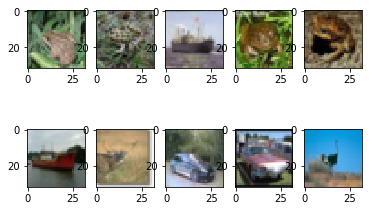

In [41]:
for i in range(10):
    ind=np.random.random_integers(1,1000)
    im=np.expand_dims(x_test[ind],axis=0)
    result=np.argmax(model.predict(im))
    print(labels[result])
    #print(im)
    plt.subplot(2,5,i+1)
    im=x_test[ind].reshape(im.shape[1],im.shape[2],3)
    im=np.uint8((im)*(std)+mean)
    plt.imshow(im)
plt.show()